# Full pipeline demo: 

Estimate the water plane from a google street view image :

1. Estimate the depth from single street view image

From the depth and camera parameters, we reconstruct relative 3D coordinates up to a scale factor

2. Estimate object size

In the dataset we know the statistical dimension (H, W, L) of several object categories (cars, truck, pedestrians etc), we have a dictionnary with mapping a category to these dimensions. Given an image, we first detect with 2D bounding box and a semantic label of all the objects known in the dictionnary.  

Given a bounding box and a category, there is a model that compute the 3D bounding box. [see readme]

3. Semantic segmentation of the natural image

4. Filter objects with respect to the percentage of pixels annotated as belonging to the category of the object in the bounding box: for example if a bounding box of a car only has less than 30 % of its pixels categorized as car we reject the object.

To compute a binary mask of every pixels below a certain height (called threshold in meters)

1. Fix the threshold (in meter)

2. Mapping meters to relative distance. 

For every object: compute        

threshold_in_rel_coordinate = z_min + (z_max-z_min)\*threshold/H 
    with H the Height of the detected object
    
z_min is the smallest z value in 3D reconstructed coordinates corresponding to the pixels belonging to the object (we filters the pixels with the semantic segmentation)
same for z_max

By computing the average of these threshold we map the threshold in meters with the relative distance.





In [4]:
%load_ext autoreload

In [5]:
%autoreload
import os
import time
from PIL import Image
from math import sin, cos, pi, tan
import numpy as np
import cv2
import argparse
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import vgg
from BoundingBox3D.yolo.yolo import cv_Yolo
from BoundingBox3D.torch_lib.Dataset import *
from BoundingBox3D.torch_lib import Model, ClassAverages
from BoundingBox3D.library.Math import *
from BoundingBox3D.library.Plotting import *
import os
from data_utils import download_SV_img as download_sv

from MegaDepth import test as megadepth_test

from MegaDepth.options.train_options import TrainOptions

from viz import show_2D_bbox, show_flood, show_seg_mask
from segmentation import segmentation
from core_utils import filter_segmentation, get_thresh_coords_megadepth
from math import atan

In [6]:
# Define some gps location for street view 
addresses = np.array([
            [45.5306086,-73.6148085],
            [45.530608, -73.614964],
            [45.5305405,-73.6155206],
            [45.530095, -73.615002],
            [45.530178, -73.614715],
            [45.529515, -73.622325],
            [45.524653, -73.596550],
            [45.522775, -73.603377],
            [45.523305, -73.604910],
            [45.5227349,-73.6023362],
            [45.5231721,-73.6030411],
            [45.5231552,-73.6024024],
            [45.5235926,-73.5989186],
            [45.5236515,-73.5946721],
            [45.5234785,-73.591241],
            [45.5146551,-73.588218],
            [45.5094233,-73.5787649],
            [45.5051424,-73.578591]
            ])

In [7]:
# YOUR GOOGLE STREETVIEW API KEY 
key =  '' 

In [8]:
# Download images from the adresses
output_paths = download_sv.get_images([download_sv.param_block(address, key) for address in addresses],'./demo_data/', crop_print=20) 

All images fetched


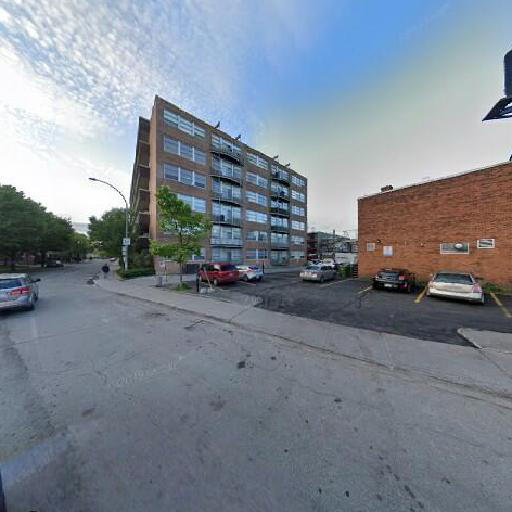

In [22]:
# Visualize one image 
selected_im = 5
img_file = output_paths[selected_im]
Image.open(img_file)

In [21]:
megadepth_test.get_depthmap_img(img_file, './demo_data/', [512,512], './MegaDepth/checkpoints/')


===========================================LOADING Hourglass NETWORK====================================================
./MegaDepth/checkpoints/test_local/best_generalization_net_G.pth
model [HGModel] was created
[512, 512]
============================= TEST ============================


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saved to files ./demo_data/gsv_000005_depth
We are done


'./demo_data/gsv_000005_depth'

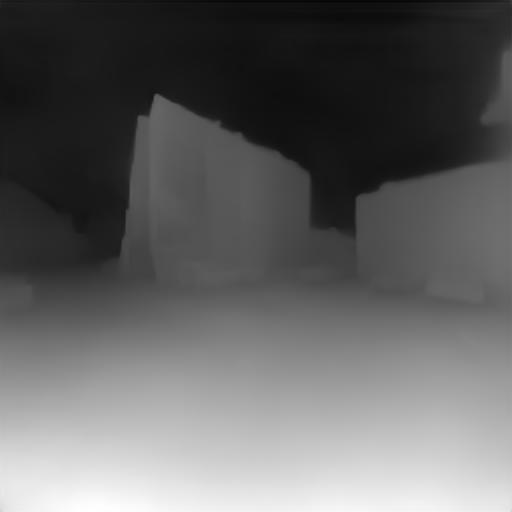

In [24]:
depth_path = './demo_data/gsv_00000'+str(selected_im)+'_depth.jpg'
Image.open(depth_path)

In [25]:
# Define weights
weights_path = "./BoundingBox3D/weights/"
yolo_path ="./BoundingBox3D/weights"

# Define the list of models
model_lst = [x for x in sorted(os.listdir(weights_path)) if x.endswith('.pkl')]
if len(model_lst) == 0:
    print('No previous model found, please train first!')
    exit()
else:
    print('Using previous model %s'%model_lst[-1])
    my_vgg = vgg.vgg19_bn(pretrained=True)
    # TODO: load bins from file or something
    model = Model.Model(features=my_vgg.features, bins=2).cuda()
    checkpoint = torch.load(weights_path + '/%s'%model_lst[-1])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

yolo = cv_Yolo(yolo_path)
averages = ClassAverages.ClassAverages()
angle_bins = generate_bins(2)

Using previous model epoch_10.pkl


(512, 512, 3)


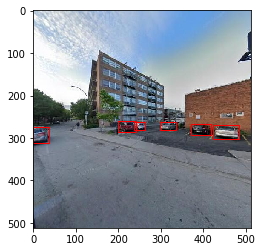

In [26]:
truth_img = cv2.imread(img_file)
img = np.copy(truth_img)
yolo_img = np.copy(truth_img)
detections = yolo.detect(yolo_img)

show_2D_bbox(img_file, detections)

Segmentation done


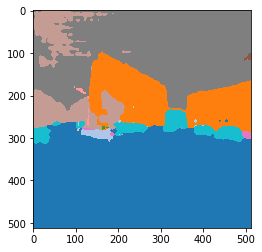

In [27]:
masks = segmentation.segment_19classes([img_file], "/network/tmp1/ccai/checkpoints/roadSegmentation/resnet_34_8s_cityscapes_best.pth" , './demo_data/')

show_seg_mask(masks[0])

In [52]:
classes = {'car':13, 'truck':14, 'motorcycle':17}
depth = np.array(Image.open(depth_path))
#The initial FOV in the API was 120°. But we center-cropped the image, taking out margins of 20 pixels on all sides (to get rid of the watermarks)
# We then resized the image to 512*512 so that we could apply MegaDepth on it ( some pixels are dilated)

H, W = 512, 512
init_FOVx = pi/3   #half FOV
init_FOVy = pi/3   #half FOV
FOVx =  2*atan(tan(init_FOVx)*((W/2)-20)/(W/2) )#initial FOV - angle corresponding to the crop
FOVy =  2*atan(((H/2)-20)/(H/2) * tan(init_FOVy))

mask = np.load(masks[0])

#Enter metric threshold
threshold = 0.5

coords, thresholds = get_thresh_coords_megadepth(img, threshold, depth, FOVx, FOVy, detections, mask, classes, model,pix_threshold = 0.3, epsilon = 0)

[0, 1, 2, 3, 4, 5]
-3.4670813612713793 -6.535485580118161
[1.5078387 1.6169077 3.680423 ]
height of the detected object of class car in meters is : 1.5078387
-4.06653700948503 -5.875960003917626
[1.5359887 1.6568745 4.01343  ]
height of the detected object of class car in meters is : 1.5359887
-3.940424032290991 -6.43519290622439
[1.4720359 1.6255621 3.1529796]
height of the detected object of class car in meters is : 1.4720359
-5.951066363831118 -8.151790509769125
[1.5041797 1.6258538 3.7576785]
height of the detected object of class car in meters is : 1.5041797
-3.138898999728689 -5.374245955225479
[1.4949925 1.6263638 3.9018233]
height of the detected object of class car in meters is : 1.4949925
-3.474838698527971 -4.992213304000474
[1.546597  1.6583745 4.151463 ]
height of the detected object of class car in meters is : 1.546597


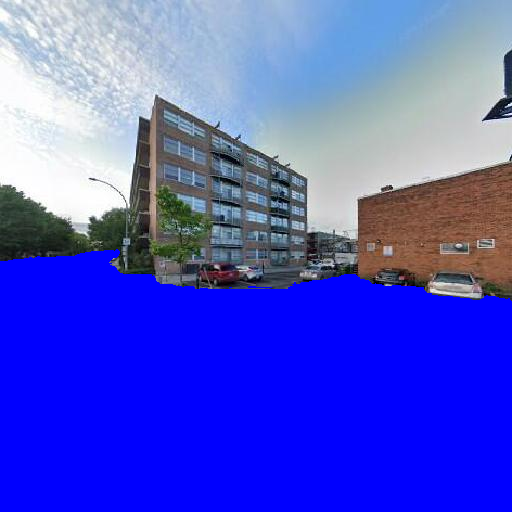

<Figure size 432x288 with 0 Axes>

In [53]:
show_flood(img, np.mean(thresholds), coords)

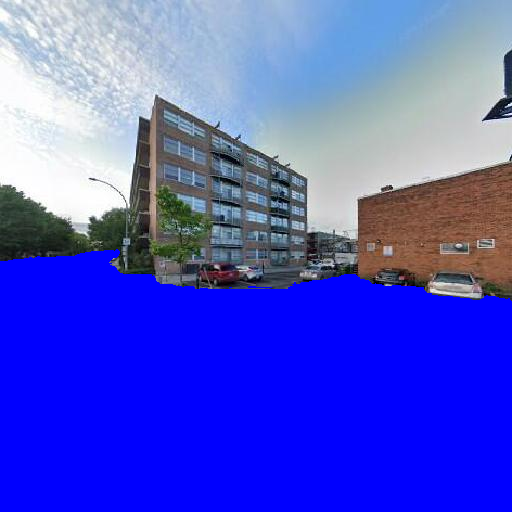

<Figure size 432x288 with 0 Axes>

In [54]:
threshold1 = np.mean(thresholds)
import matplotlib.pyplot as plt
#def show_flood(img, threshold, coords, save_path = None):
fig = plt.figure()
red = [0,0,255]
blue =[255,0,0]
#flood everything under threshold
flood = np.where(coords[:,:,1]< threshold)
colors = img.copy().reshape(512,512,3)
colors[flood[0], flood[1], : ] = red
flooded_im = colors.reshape(512,512,3)

flood = np.where(coords[:,:,1]< threshold1)
colors = img.copy().reshape(512,512,3)
colors[flood[0], flood[1], : ] = blue
flooded_im = colors.reshape(512,512,3)

img_pil = cv2.cvtColor(flooded_im, cv2.COLOR_BGR2RGB)
im = Image.fromarray(img_pil)
im
